# Link to my GitHub Repo:
# https://github.com/aniawebb/DSCI-510-FinalProject/blob/main/README.md

# _Let's get started!_
### 1. Think of your favorite musician (example: Harry Styles)
### 2. Navigate to their Spotify page online and copy the link (example: https://open.spotify.com/artist/6KImCVD70vtIoJWnq6nGn3) 
### 3. Obtain said artist's SpotifyID by copying all characters following 'artist/' (example: '6KImCVD70vtIoJWnq6nGn3') 
### 4. Save the SpotifyID to a variable named _'artist_id'_, this will be the key input in the workflow

In [1]:
artist_id = '6KImCVD70vtIoJWnq6nGn3'

### 5. Create an account through Spotify's portal for developers (https://developer.spotify.com/dashboard/login)
### 6. Obtain your unique _'client id'_ and _'client secret'_ and save to variables named accordingly, these will be used to access Spotify's API

In [2]:
client_id = "2c2e1780308747d192aba84fda1f2b85"
client_secret = "ac41fafb67e444139cab1cb15d9d2b92"

In [3]:
import requests
import base64
import datetime
from urllib.parse import urlencode
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os  
import statsmodels.api as sm
#!pip3 install pywedge
import pywedge as pw

In [4]:
def request_access_token(client_id: str, client_secret: str):
            
    """
    Generates a unique access token string which will allow us to explore the data on Spotify's API.
    
    Args:
        client_id - from developer portal account
        client_secret - from developer portal account
    Returns:
        access_token - string value which allows connections to the API
    """
      
    client_id = client_id
    client_secret = client_secret
    client_creds = f"{client_id}:{client_secret}"
    client_creds_b64 = base64.b64encode(client_creds.encode())

    token_url = "https://accounts.spotify.com/api/token"
    method = "POST"

    token_data = {
        "grant_type": "client_credentials"
    }

    token_headers = {
        "Authorization": f"Basic {client_creds_b64.decode()}"
        }

    request = requests.post(token_url, data= token_data, headers= token_headers)
    token_response = request.json()

    return token_response['access_token']

In [5]:
def get_artist(artist_id: str, export: bool):
            
    """
    Grabs your artist's name, genre, and popularity index and formats the information into a pandas dataframe. 
    The popularity index ranges from 0-100 and is calculated based on the popularity of the artist's tracks.
    
    Args:
        artist_id - unique string value for your selected Spotify artist
    Returns:
        artist_df - generates a pandas dataframe and saves results to csv file
    """
     
    headers = {
        'Authorization': 'Bearer {token}'.format(token= request_access_token(client_id, client_secret))}

    url = 'https://api.spotify.com/v1/'

    response = requests.get(url + 'artists/' + artist_id, headers=headers)
    data = response.json()
    
    df_data = {'Name': data['name'], 
     'SpotifyID': data['id'], 
     'Genres': data['genres'],
     'Popularity': data['popularity']}
    
    artist_df = pd.DataFrame(df_data) 
    
    if export is True:
        os.makedirs('tables', exist_ok=True)  
        artist_df.to_csv('tables/artist.csv') 
    else:
        return artist_df

In [6]:
def get_toptracks(artist_id: str):
            
    """
    Grabs your selected artist's top tracks along with their unique SpotifyID, popularity index (0-100) and 
    whether or not the track is explicit or not explicit.
    
    Args:
        artist_id - unique string value for your selected Spotify artist
    Returns:
        tracks_df - generates a pandas dataframe and saves results to csv file
    """
     
    headers = {
        'Authorization': 'Bearer {token}'.format(token= request_access_token(client_id, client_secret))}

    url = 'https://api.spotify.com/v1/'
    query = {
        'market': "US"
        }
    
    response = requests.get(url + 'artists/' + artist_id + '/top-tracks', headers=headers, params = query)
    toptracks = response.json()

    song_ids = []
    song_names = []
    song_popularity = []
    song_explicity = []


    for track in toptracks['tracks']:
        song_ids.append(track['id'])
        song_names.append(track['name'])
        song_popularity.append(track['popularity'])
        song_explicity.append(track['explicit'])

    df_data = {'Name': song_names, 
     'SongID': song_ids, 
     'Popularity': song_popularity,
     'Explicit': song_explicity}

    tracks_df= pd.DataFrame(df_data)
    
    os.makedirs('tables', exist_ok=True)  
    tracks_df.to_csv('tables/top_tracks.csv') 

    return tracks_df

### _Track Audio Features Definitions_ 
(https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features)

* **SongID** = The Spotify ID for the track.
* **Duration_ms** = The duration of the track in milliseconds.
* **Danceability** = Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* **Energy** = Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* **Key** = The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
* **Mode** = Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* **Speechiness** = Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* **Acousticness** = A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* **Instrumentalness** = Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* **Liveness** = Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* **Valence** = A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* **Tempo** = The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

In [7]:
def get_track_audio_features(artist_id: str):
         
    """
    Uses the get_toptracks() to obtain a list of unique Spotify SongID's for each top track to then grab each 
    track's audio features (which are described above). As with the previous functions, the data is sorted into 
    a pandas dataframe. 
    
    Args:
        artist_id - unique string value for your selected Spotify artist
    Returns:
        features_df - generates a pandas dataframe and saves results to csv file
    """
     
    tracks_df = get_toptracks(artist_id)
    track_audio_features_list = []
    
    for song_id in tracks_df['SongID']:
        headers = {
            'Authorization': 'Bearer {token}'.format(token= request_access_token(client_id, client_secret))}

        url = 'https://api.spotify.com/v1/'

        response = requests.get(url + 'audio-features/' + song_id, headers=headers)

        track_audio_features = response.json()
        track_audio_features_list.append(track_audio_features)
    
    SongID = []
    Duration_ms = []
    Danceability = []
    Energy = []
    Key = []
    Mode = []
    Speechiness = []
    Acousticness = []
    Instrumentalness = []
    Liveness = []
    Valence = []
    Tempo = []

    for track in track_audio_features_list:
        SongID.append(track['id'])
        Duration_ms.append(track['duration_ms'])
        Danceability.append(track['danceability'])
        Energy.append(track['energy'])
        Key.append(track['key'])
        Mode.append(track['mode'])
        Speechiness.append(track['speechiness'])
        Acousticness.append(track['acousticness'])
        Instrumentalness.append(track['instrumentalness'])
        Liveness.append(track['liveness'])
        Valence.append(track['valence'])
        Tempo.append(track['tempo'])

    df_data = {'SongID': SongID, 
     'Song Length': Duration_ms,
     'Key': Key,
     'Mode': Mode,
     'Tempo': Tempo,
     'Danceability': Danceability,
     'Energy': Energy,
     'Speechiness': Speechiness,
     'Acousticness': Acousticness,
     'Instrumentalness': Instrumentalness,
     'Liveness': Liveness,
     'Valence': Valence}

    features_df = pd.DataFrame(df_data)
    features_df['Name'] = tracks_df['Name']
    
    os.makedirs('tables', exist_ok=True)  
    features_df.to_csv('tables/features.csv') 
    
    return features_df

In [8]:
def get_recommendations(artist_id: str):
    
    """
    Uses the get_toptracks() and get_artist() to obtain seed tracks and seed genres to input into a request query. 
    With this information, I obtain suggested artist names, song names, their popularity, and whether the songs were
    explicit. As with the previous functions, the data is sorted into a pandas dataframe. 
    
    Args:
        artist_id - unique string value for your selected Spotify artist
    Returns:
        recommended_artists_df - generates a pandas dataframe and saves results to csv file
    """
     
    toptracks = get_toptracks(artist_id)
    artist_df = get_artist(artist_id, False)
    seed_artists = artist_id
    
    seed_genres = artist_df['Genres'].tolist()
    seed_tracks = toptracks['SongID'][0:3].tolist()

    headers = {
        'Authorization': 'Bearer {token}'.format(token= request_access_token(client_id, client_secret))}

    query = {
        'market': "US",
        'limit': 100,
        'seed_artists': seed_artists,
        'seed_genres':  str(seed_genres[0]),
        'seed_tracks': seed_tracks
        }

    url = 'https://api.spotify.com/v1/'

    response = requests.get(url + 'recommendations', headers=headers, params=query) 

    recommendations = response.json()

    song_names = []
    artist_popularity = []
    songs_explicit = []
    album_info = []
    artist_names = []
    artist_ids = []
    genres = []

    for track in recommendations['tracks']:
        song_names.append(track['name'])
        artist_popularity.append(track['popularity'])
        songs_explicit.append(track['explicit'])

    for track in recommendations['tracks']:    
        album_info.append(track['album'])

    for i in range(0,100):
        artist_names.append([d['name'] for d in [d['artists'] for d in album_info][i]])

    for i in range(0,100):
        artist_ids.append([d['id'] for d in [d['artists'] for d in album_info][i]])

    df_data = {'Artist ID': artist_ids}
    id_df = pd.DataFrame(df_data) 
    id_df['Artist ID'] = id_df['Artist ID'].str[0]

    for artist_id in id_df['Artist ID'].to_list():
        artist_df = get_artist(artist_id, False)
        genres.append(artist_df['Genres'].tolist())

    df_data = {'Artist Name': artist_names, 
     'Artist ID': artist_ids, 
     'Artist Genre': genres,
     'Song Name': song_names,          
     'Popularity': artist_popularity,
     'Explicit': songs_explicit}

    recommended_artists_df = pd.DataFrame(df_data) 
    recommended_artists_df['Artist Name'] = recommended_artists_df['Artist Name'].str[0]
    recommended_artists_df['Artist ID'] = recommended_artists_df['Artist ID'].str[0]
    recommended_artists_df['Artist Genre'] = recommended_artists_df['Artist Genre'].str[0]

    os.makedirs('tables', exist_ok=True)  
    recommended_artists_df.to_csv('tables/recommended_artists.csv')
    
    return recommended_artists_df

## _Now that we have the data, time for analysis:_
### Scatterplot Charts

In [9]:
def make_scatterplots(features_df):
        
    """
    Generates scatter plots which look at the relationships between certain track audio features. The coloration 
    of the scatterplot points is based on the song name, and the point size is delineated by the song length. 
    
    Args:
        features_df - get_track_audio_features(artist_id)
    Returns:
        12 scatterplots: each with different feature relationships, saved to file 
    """
  
    for i in ['Danceability', 'Speechiness', 'Instrumentalness']:
        for k in ['Energy', 'Acousticness', 'Liveness', 'Valence']:
            plt.figure(figsize=(5,5))
            plt.title(i + " versus " + k + ",\nwith the sizes of the points representing song length.", y=1.02, bbox={'facecolor':'0.8', 'edgecolor':'purple', 'pad':5})
            song_scatter = sns.scatterplot(data= features_df, 
                                 x= i, 
                                 y= k, 
                                 hue='Name', 
                                 palette='tab10', 
                                 size='Song Length', 
                                 sizes=(100,1000), 
                                 alpha=0.7)

            handle,label = song_scatter.get_legend_handles_labels()
            song_scatter.legend(handle[1:11], label[1:11], bbox_to_anchor=(1.02, 1), loc='upper left',
                      fancybox=True, shadow=True, ncol=1, title= "Song Names")

            os.makedirs('figures', exist_ok=True)  
            plt.savefig('figures/' + i + "vs" + k, bbox_inches='tight')

### Pie Charts

In [10]:
def make_features_piecharts(features_df): 
        
    """
    Generates unique pie charts: one for each top track. The pie chart slices consist of the track audio features 
    which have values ranging from 0-1, so the variability can be easily analyzed.
    
    Args:
        features_df - get_track_audio_features(artist_id)
    Returns:
        10 pie charts: one for each song, saved to file  
    """
  
    i = 0 
    for i in range(0,10):
        pie_slices = ['Danceability','Energy','Speechiness','Acousticness','Instrumentalness','Liveness','Valence']
        values = (features_df.iloc[i]).tolist()[5:12]

        pie, ax = plt.subplots()
        ax.pie(values, labels=pie_slices, autopct='%1.1f%%')
        ax.axis('equal') 

        plt.title(((features_df.iloc[i]).tolist()[-1])+"'s Track Audio Features", bbox={'facecolor':'0.8', 'edgecolor':'yellow', 'pad':5})
        
        os.makedirs('figures', exist_ok=True)  
        plt.savefig('figures/' + ((features_df.iloc[i]).tolist()[-1]), bbox_inches='tight')

        i += 1

In [11]:
def make_genres_piecharts(recommended_artists_df): 
        
    """
    Generates a pie chart with slices of the recommended genres calculated in get_recommendations(artist_id)
    
    Args:
        recommended_artists_df - get_recommendations(artist_id)
    Returns:
        1 pie chart: saved to file 
    """
  
    plt.figure(figsize=(10,10))
    plt.title("Genres of Recommended Music", y=1.01, bbox={'facecolor':'0.8', 'edgecolor':'yellow', 'pad':5})
    recommended_artists_df.groupby('Artist Genre').size().sort_values().plot.pie(autopct = '%1.1f%%', 
                                                                   rotatelabels = True, 
                                                                   cmap = 'viridis',
                                                                   pctdistance = .95, 
                                                                   labeldistance = 1.01,
                                                                   textprops = {'fontsize': 6},
                                                                   wedgeprops = {"width":0.5})
    plt.ylabel('')
    plt.text(.05, -1.3, "This chart plots 100 recommended songs based on your favorite artist", ha='center', weight='bold')
    plt.tight_layout()

    os.makedirs('figures', exist_ok=True)  
    plt.savefig('figures/Recommended_Genres.png', bbox_inches='tight')
    plt.show()

In [12]:
def make_artists_piecharts(recommended_artists_df): 
            
    """
    Generates a pie chart with slices of the recommended artists calculated in get_recommendations(artist_id)
    
    Args:
        recommended_artists_df - get_recommendations(artist_id)
    Returns:
        1 pie chart: saved to file 
    """
    
    plt.figure(figsize=(10,10))
    plt.title("Recommended Artists", y=1.01, bbox={'facecolor':'0.8', 'edgecolor':'yellow', 'pad':5})
    recommended_artists_df.groupby('Artist Name').size().sort_values().plot.pie(autopct = '%1.1f%%', 
                                                                   rotatelabels = True, 
                                                                   cmap = 'viridis',
                                                                   pctdistance = .95, 
                                                                   labeldistance = 1.01,
                                                                   textprops = {'fontsize': 6},
                                                                   wedgeprops = {"width":0.5})
    plt.ylabel('')
    plt.text(.05, -1.3, "This chart plots 100 recommended artists based on your favorite artist", ha='center', weight='bold')
    plt.tight_layout()

    os.makedirs('figures', exist_ok=True)  
    plt.savefig('figures/Recommended_Artists.png', bbox_inches='tight')
    plt.show()

### Regression Analysis Using _statsmodels_

In [13]:
def multiple_regression(features_df, toptracks):
        
    """
    As a statistical analysis, I conducted a multiple linear regression using track audio features ranging 
    between 0-1 as the independent variables and the popularity index for each song from the get_toptracks() 
    function.
    
    Args:
        features_df - get_track_audio_features(artist_id)
        toptracks - get_toptracks(artist_id)
    Returns:
        txt_file: containing the summary from the OLS, saved to file  
    """
    
    features_df['Popularity'] = toptracks['Popularity']

    #dependent variable:
    Y = features_df['Popularity']

    #independent variables: only using those features which vary from 0-1 to keep the scale comparable
    X = features_df[['Danceability','Energy','Speechiness','Acousticness','Instrumentalness','Liveness','Valence']]

    X = sm.add_constant(X)
    multiple_linear_regression = sm.OLS(Y, X).fit()

    with open('tables/track_audio_feature_regression_results.txt', 'w') as file:
        file.write(multiple_linear_regression.summary().as_text())
        
    return(multiple_linear_regression.summary())

### Choose Your Visualization! 
* To close out the Spotify API analysis, I'm pulling in the data from _get_track_audio_features()_ and inputting it into a pwedge pipeline. This package easily generates interactive plots using drop-down menus and has a quick output time. 
* If you would like to download any of the interactive plots, select the camera icon, "Download plot as png"

In [14]:
features_df = get_track_audio_features(artist_id)
pwedge_charts = pw.Pywedge_Charts(features_df, c=None, y = 'Name')
pwedge_plots = pwedge_charts.make_charts()

/Users/aniawebb/opt/anaconda3/lib/python3.9/site-packages/pywedge/pywedge.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  self.X = self.train.drop(self.y,1)


HTML(value='<h2>Pywedge Make_Charts </h2>')

/var/folders/1w/_vpyrn9s187dzpjkl7_nj2q40000gn/T/ipykernel_64515/3727866874.py:18: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/Users/aniawebb/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10

/Users/aniawebb/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



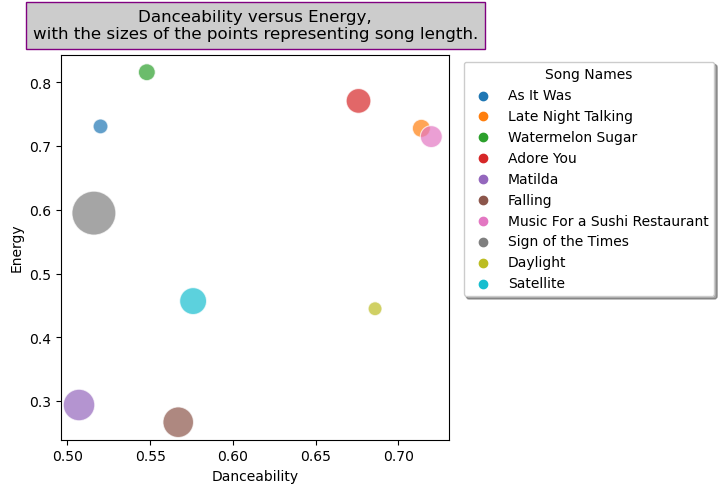

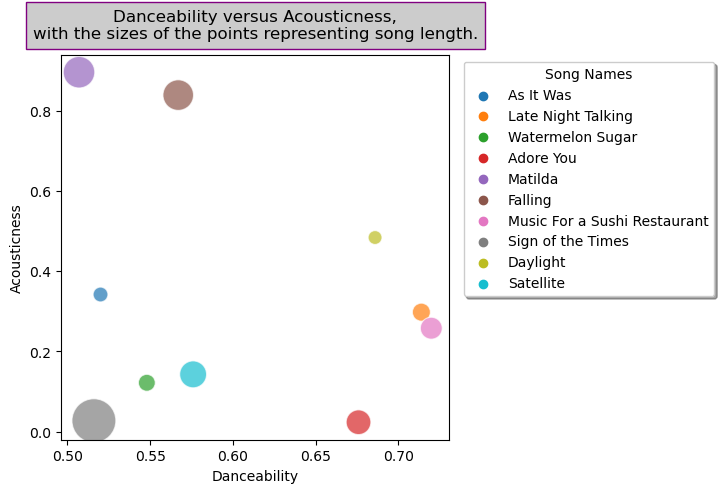

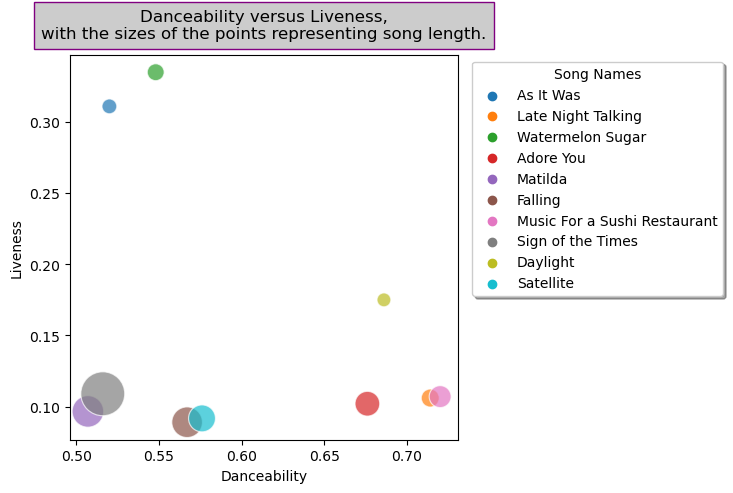

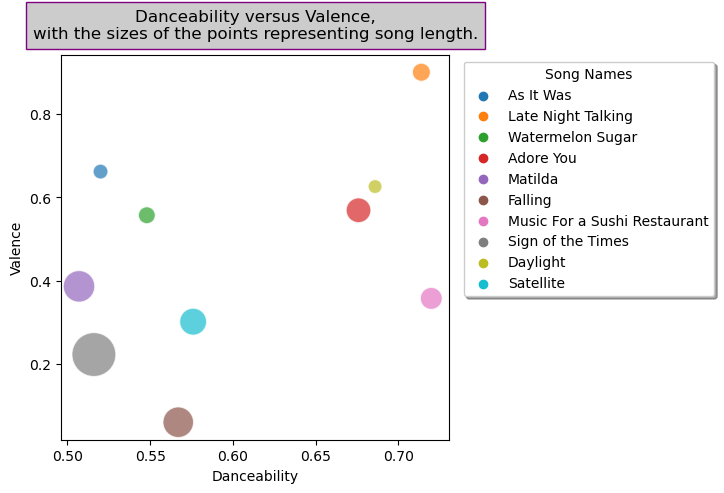

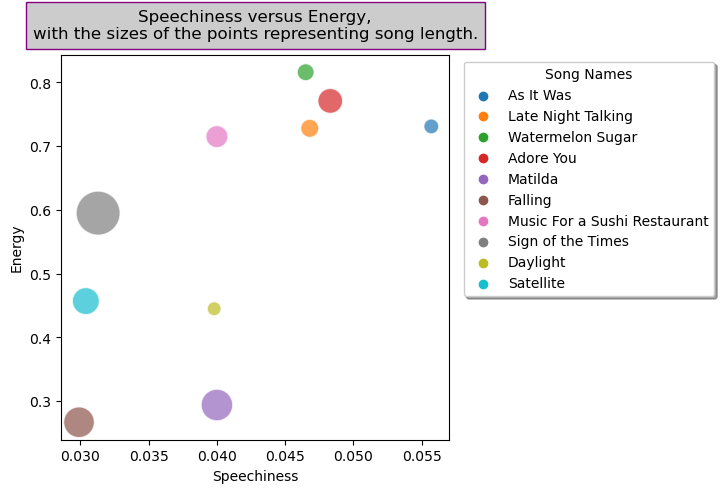

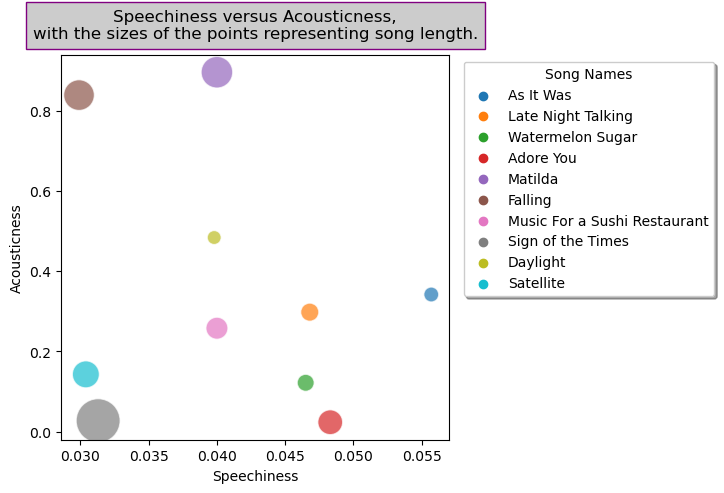

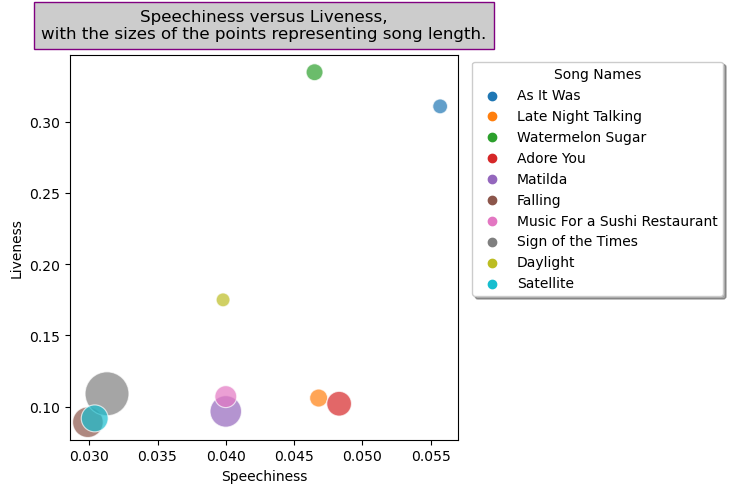

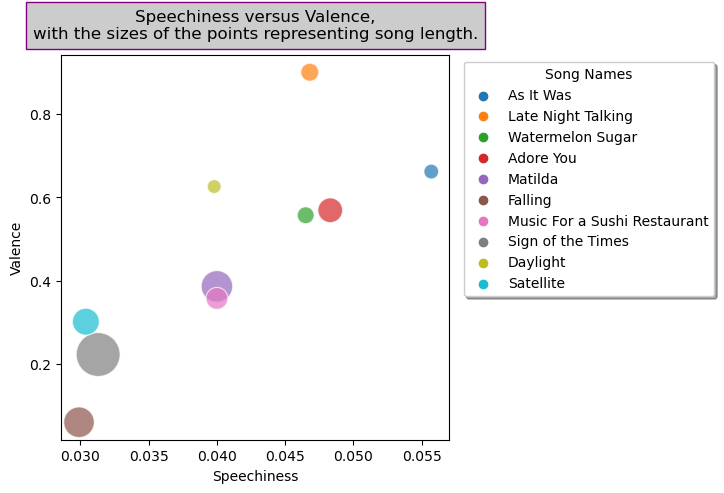

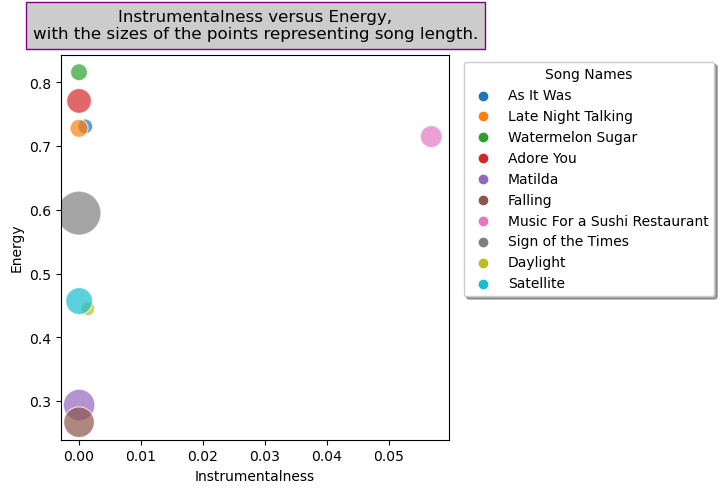

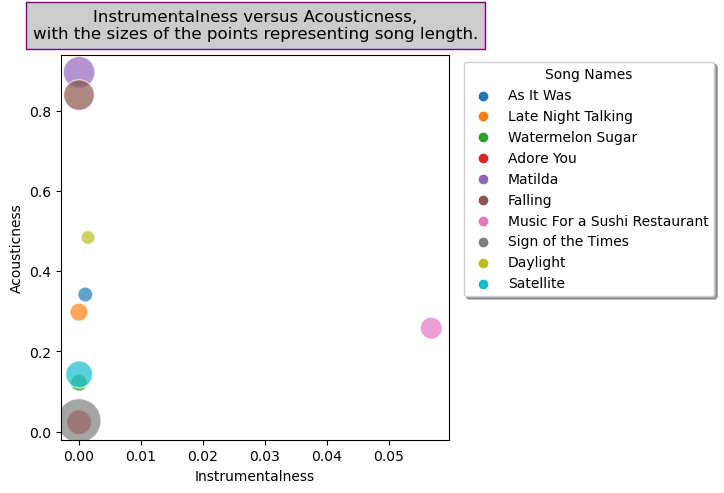

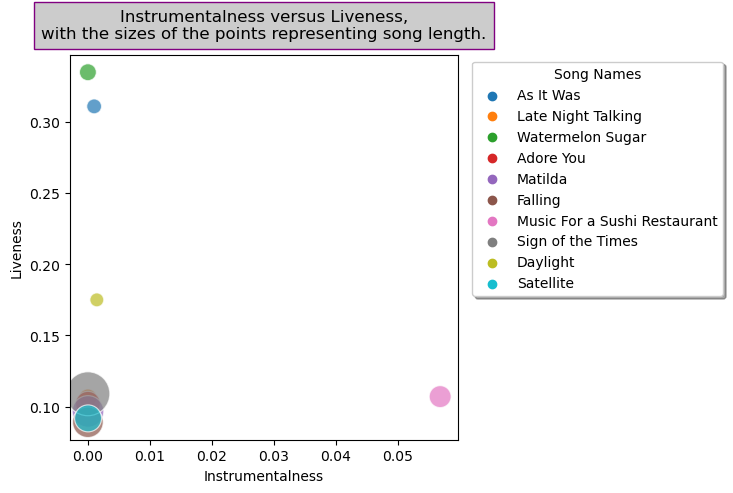

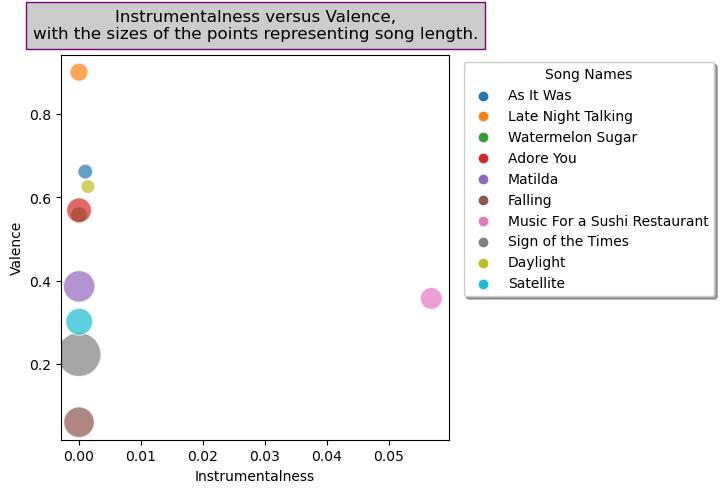

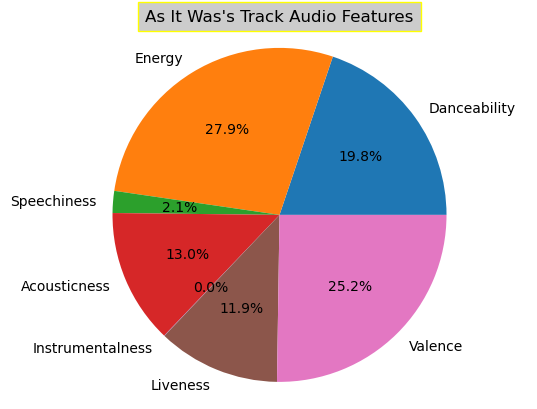

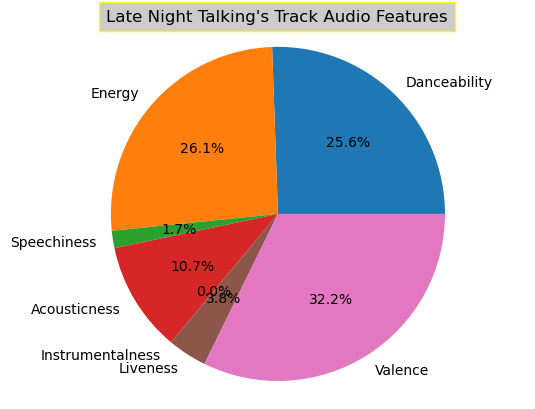

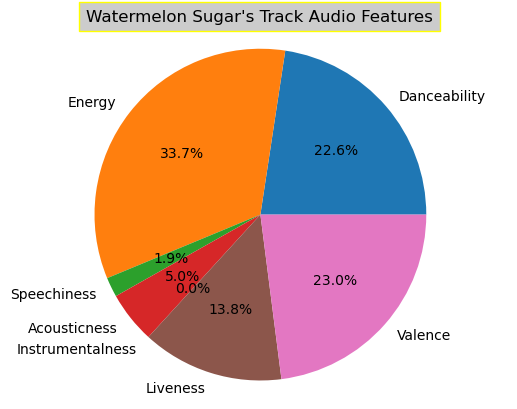

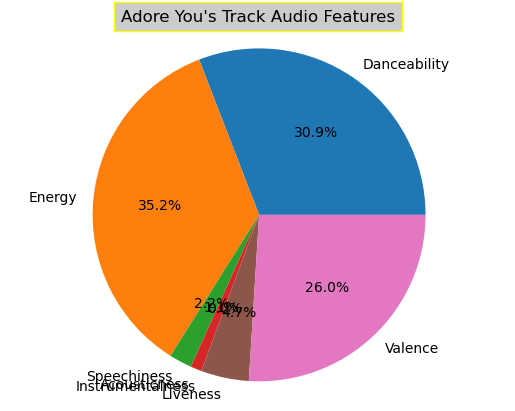

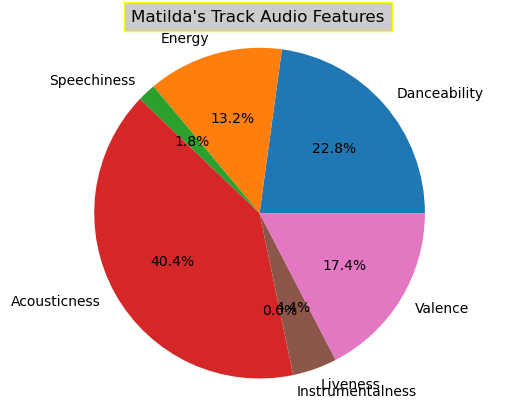

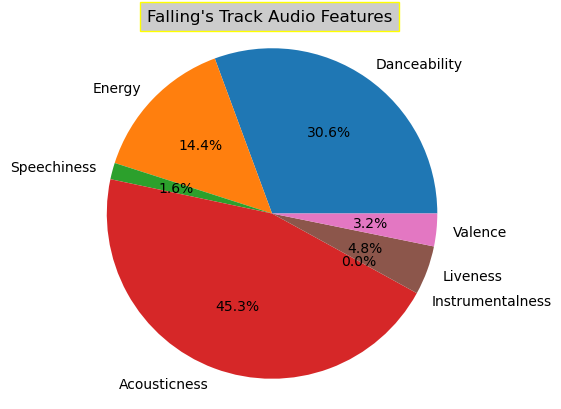

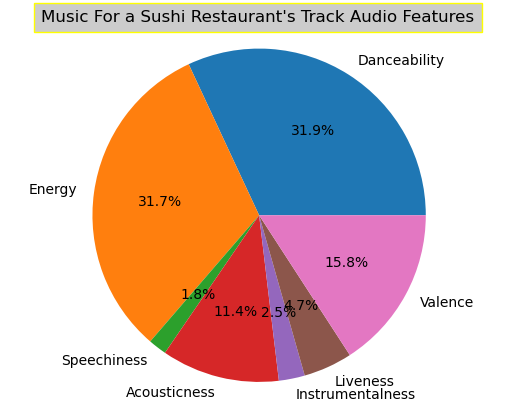

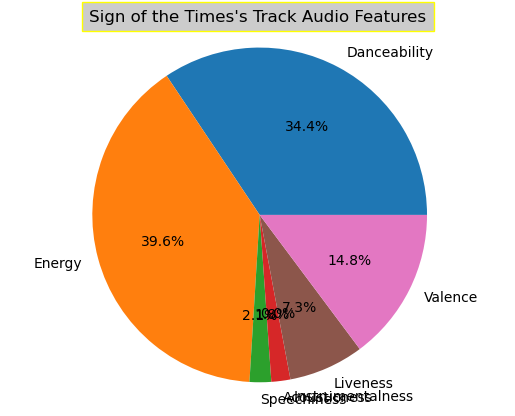

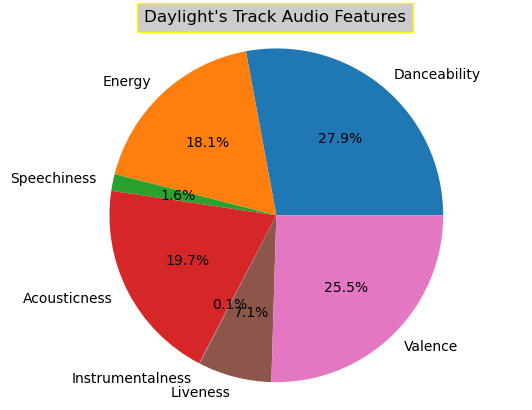

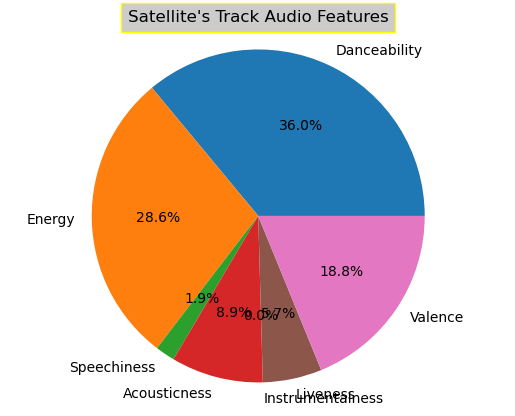

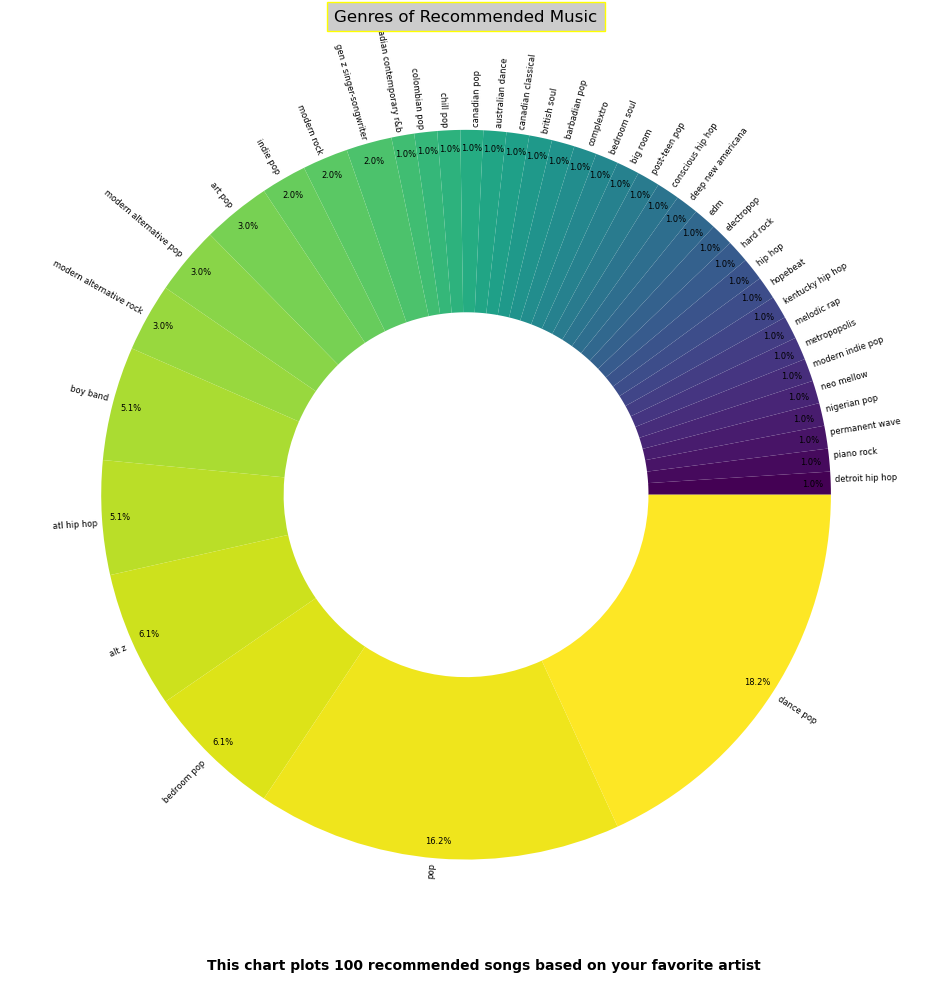

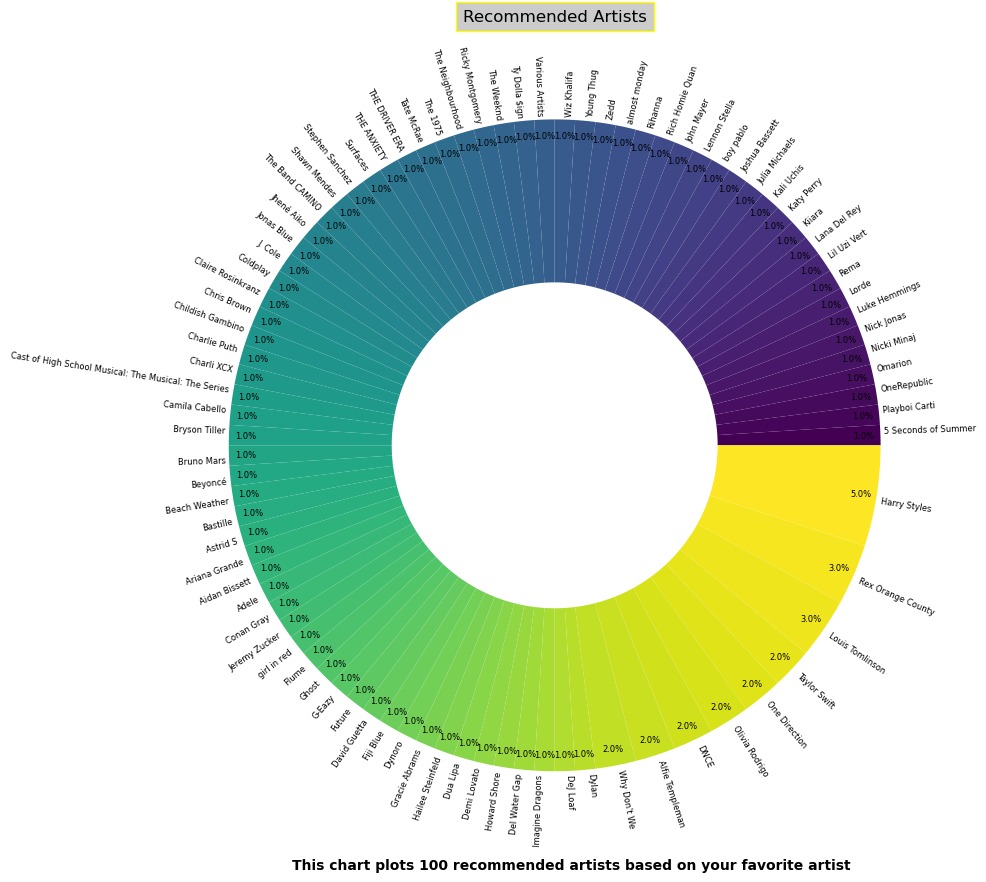

In [15]:
if __name__ == '__main__':
    artist_df = get_artist(artist_id, True)
    toptracks = get_toptracks(artist_id)
    features_df = get_track_audio_features(artist_id)
    recommended_artists_df = get_recommendations(artist_id) 
    make_scatterplots(features_df)
    make_features_piecharts(features_df)
    multiple_regression(features_df, toptracks)
    make_genres_piecharts(recommended_artists_df)
    make_artists_piecharts(recommended_artists_df)